In [1]:
import numpy as np          
from matplotlib import pyplot as plt

s0 = np.random.normal(100,1,200)
s1 = [50,61,41,62,35,58,66,50,51,51,52,80,130,150,170,
    200,200,201,202,210,200,200,400,500,600,600,400,350,
    200,200,201,202,210,200,200,201,202,210,200,200,201,202,201,202,210,200,200,201,202] 

def readFromRecord(path):
    with open(path, 'r') as f:
        data = f.read()
        if len(data) == 0: 
            return []
        data = data.split(',')
        data = [int(string) for string in data]
        return data

In [73]:
import math
def Hysteresis_log_interval_changeA(s, f1=0.1, f2=0.25, A1=0, A2=0.7, n=5, bMean=True, blog=False, linear=True):
    def calLogistic(deltaLux, a2, blog):
        if blog:
            return a2*np.exp(0.01*np.exp(deltaLux))/(1+a2*(np.exp(0.01*np.exp(deltaLux))-1))
        else:
            return a2*np.exp(0.01*deltaLux)/(1+a2*(np.exp(0.01*deltaLux)-1))

    result = []
    res_idx = []
    last_min = 9999999
    last_max = -1
    last_min2 = 9999999
    last_max2 = -1
    factor = f1
    factor2 = f2
    a1 = A1
    a2 = A2
    a = 0.7
    a_list = []

    minmax_list = [[], [], [], []]
    for i in range(int(len(s)/n)):
        cur_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        if len(result) > 0:
            if blog:
                last_min = max(0, math.log(result[-1]+1) - math.log(result[-1]+1)*factor)
                last_max = max(math.log(5), math.log(result[-1]+1) + math.log(result[-1]+1)*factor)
                last_min2 = max(0, math.log(result[-1]+1) - math.log(result[-1]+1)*factor2)
                last_max2 = max(math.log(10), math.log(result[-1]+1) + math.log(result[-1]+1)*factor2)
            else:
                last_min = max(0, result[-1] - result[-1]*factor)
                last_max = max(5, result[-1] + result[-1]*factor)
                last_min2 = max(0, result[-1] - result[-1]*factor2)
                last_max2 = max(10, result[-1] + result[-1]*factor2)

        if len(cur_s) == 0:
            break

        if bMean:
            mean_s = np.mean(cur_s)   # median
        else:
            mean_s = np.median(cur_s)   # median
        cur_stable = 0
        if len(result) == 0:
            pass
        else:
            if blog:
                cur_stable = math.log(mean_s+1)
            else:
                cur_stable = mean_s
                
            if cur_stable <= last_max and cur_stable >= last_min:
                a = 1
            # elif cur_stable > last_max2 or cur_stable < last_min2:
            #     a = a2
            elif cur_stable > last_max2:
                a = calLogistic(cur_stable-last_max2, a2, blog)
                # print('a:', a, ',', cur_stable-last_min2)
            elif cur_stable < last_min2:
                a = calLogistic(abs(last_min2-cur_stable), a2, blog) 
                # print('a:', a, ',', abs(last_min2-cur_stable))
            else:
                if linear:
                    if cur_stable > last_max and cur_stable <= last_max2:
                        a = (a1-a2)*(cur_stable-last_max2)/(last_max-last_max2) + a2
                    elif cur_stable > last_min2 and cur_stable < last_min:
                        a = (a1-a2)*(cur_stable-last_min2)/(last_min-last_min2) + a2
                else:
                    if cur_stable > last_max and cur_stable <= last_max2:
                        m = (a2-a1) / np.power((0.5*last_max - 0.5*last_max2), 2)
                        a = m * np.power((cur_stable - 0.5*(last_max2+last_max)), 2) + a1
                    elif cur_stable > last_min2 and cur_stable < last_min:
                        m = (a2-a1) / np.power((0.5*last_min - 0.5*last_min2), 2)
                        a = m * np.power((cur_stable - 0.5*(last_min2+last_min)), 2) + a1

        a_list.append(a)

        if len(result) == 0:
            if bMean:
                res = np.mean(cur_s)
            else:
                res = np.median(cur_s)
        else:
            if bMean:
                res = (1-a)*np.mean(cur_s) + a*result[-1]  # a越小,当前值占比更大
            else:
                res = (1-a)*np.median(cur_s) + a*result[-1]

        # print("min=",last_min, "cur=", cur_stable, "max=", last_max)
        if last_max != -1:
            minmax_list[0].append(last_min)
            minmax_list[1].append(cur_stable)
            minmax_list[2].append(last_max)
            minmax_list[3].append((i+1)*n)
        result.append(res)
        res_idx.append((i+1)*n)
    return result, res_idx, minmax_list, a_list

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math

def checkOneSide(lux, stableLux, last):
    if stableLux == -1 or lux == stableLux or (last - stableLux)/(lux - stableLux) > 0:
        return True
    else:
        return False

def calRMSStable(lux_list):
    RMS = math.sqrt(np.sum(np.array(lux_list)**2, dtype=float) / len(lux_list)) 
    return RMS

def calSTDRMSStable(lux_list, lastStable):
    std = np.std(lux_list)
    RMS = math.sqrt(np.sum(np.array(lux_list)**2, dtype=float) / len(lux_list)) 
    delta = lastStable - RMS
    return lastStable - (delta / (std + 1))

def AIBrightness(lux_list, need_small, always_usd_std):
    temp = []
    stable_list = []
    stable_idx = []
    noiseNum = 0
    noiseNum_th = 1
    checkSize = 4
    isDownFromLowLux = False
    DARK_LUX_THRESHOLD = 36
    for idx, lux in enumerate(lux_list):
        if len(temp) == 0:
            temp.append(lux)
        else:
            if len(stable_list) > 0:
                isDownFromLowLux = (stable_list[-1] < DARK_LUX_THRESHOLD) and (lux <= stable_list[-1])
                bOnOneSide = checkOneSide(lux, stable_list[-1], temp[0])
            else:
                bOnOneSide = checkOneSide(lux, -1, temp[0])
            if bOnOneSide:
                temp.append(lux)
            else:
                noiseNum += 1

            if(noiseNum >= noiseNum_th):
                noiseNum = 0
                temp = []
                temp.append(lux)
                continue
        
            if len(stable_list) == 0 or lux > stable_list[-1]:
                checkSize = 4
            else:
                if isDownFromLowLux:
                    checkSize = 10
                else:
                    checkSize = 6

            if len(temp) >= checkSize:
                stableLux = -1
                if always_usd_std:
                    if len(stable_list) > 0:
                        stableLux = calSTDRMSStable(temp, stable_list[-1])
                        stableLux = stableBySection(stableLux, stable_list[-1], need_small)
                    else:
                        stableLux = calRMSStable(temp)
                else:
                    stableLux = calRMSStable(temp)
                    if isDownFromLowLux and stableLux < stable_list[-1]:
                        stableLux = calSTDRMSStable(temp, stable_list[-1])
                    if len(stable_list) > 0:
                        stableLux = stableBySection(stableLux, stable_list[-1], need_small)

                stable_list.append(stableLux)
                stable_idx.append(idx)
                noiseNum = 0
                temp = []

    return stable_list, stable_idx

def stableBySection(curLux, lastStable, need_small):
    if(lastStable == -1):
        return curLux
    ### large
    # left
    big_left = lastStable
    if lastStable < 30:
        big_left = lastStable / 4.0
    elif lastStable >= 30 and lastStable < 500:
        big_left = lastStable / 10.0 + 4.5
    elif lastStable >= 500 and lastStable < 8600:
        big_left = lastStable / 1.5 - 278.83
    
    # right
    big_right = lastStable
    if lastStable < 20:
        big_right = lastStable * 2.5
    elif lastStable >= 20 and lastStable < 35:
        big_right = lastStable * 36.0 - 670
    elif lastStable >= 35 and lastStable < 500:
        big_right = lastStable * 2.25 + 511.25
    elif lastStable >= 500 and lastStable < 8600:
        big_right = lastStable * 2.0 + 636.25
    big_right = max(5, big_right)

    # big_left = min(8600, big_left)
    # big_right = min(8600, big_right)

    if need_small:
        ### small
        # left
        small_left = big_left*0.6 + curLux*0.4
        # right
        small_right = big_right*0.6 + curLux*0.4
        if curLux > small_right and curLux < big_right:
            return curLux + (big_right-curLux)*0.1
        elif curLux > big_left and curLux < small_left:
            return curLux - (curLux-big_left)*0.1
        elif curLux >= small_left and curLux <= small_right:
            return lastStable
        else:
            return curLux
    else:
        if curLux <= big_right and curLux >= big_left:
            return lastStable
        else:
            return curLux

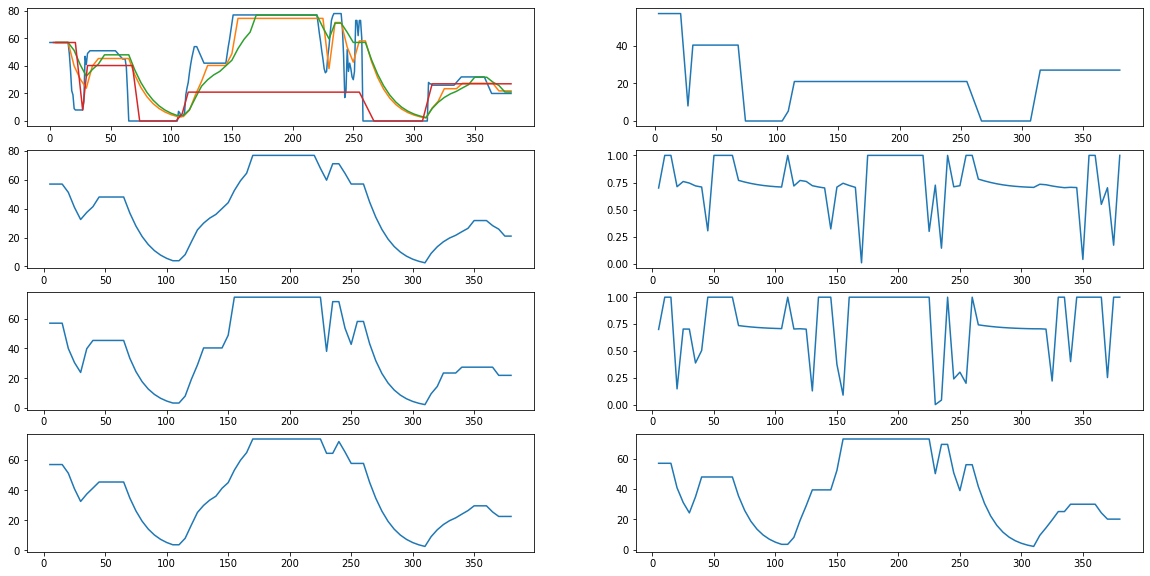

In [76]:
s = readFromRecord('night.txt')  # night daywalk daybike room
plt.figure(figsize = (20,10))

list_s, res_idx, minmax_list, a_list = Hysteresis_log_interval_changeA(s, f1=0.15, f2=0.25, A1=0, A2=0.7, n=5, bMean=False, blog=False, linear=False)
list_s2, res_idx2, minmax_list2, a_list2 = Hysteresis_log_interval_changeA(s, f1=0.05, f2=0.25, A1=0, A2=0.7, n=5, bMean=False, blog=True, linear=False)
stable_list, stable_idx = AIBrightness(s, need_small=True, always_usd_std=False)
list_s3, res_idx3, minmax_list3, a_list3 = Hysteresis_log_interval_changeA(s, f1=0.15, f2=0.25, A1=0, A2=0.7, n=5, bMean=False, blog=False, linear=True)
list_s4, res_idx4, minmax_list4, a_list4 = Hysteresis_log_interval_changeA(s, f1=0.05, f2=0.25, A1=0, A2=0.7, n=5, bMean=False, blog=True, linear=True)

mk = '.'
mk = None
col = 4
row = 2

plt.subplot(col,row,1)
plt.plot(s)
plt.plot(res_idx2, list_s2, marker=mk)
plt.plot(res_idx, list_s, marker=mk)
plt.plot(np.array(stable_idx), np.array(stable_list), marker=mk)

plt.subplot(col,row,2)
plt.plot(np.array(stable_idx), np.array(stable_list), marker=mk)

# plt.plot(minmax_list[3], minmax_list[1], linestyle="-", marker='.')
# plt.plot(minmax_list[3], minmax_list[0], linestyle="-.")
# plt.plot(minmax_list[3], minmax_list[2], linestyle="-.")

plt.subplot(col,row,3)
plt.plot(res_idx, list_s, marker=mk)
plt.subplot(col,row,4)
plt.plot(res_idx, a_list, marker=mk)
# print(a_list)
# print('\n')

plt.subplot(col,row,5)
plt.plot(res_idx2, list_s2, marker=mk)
plt.subplot(col,row,6)
plt.plot(res_idx2, a_list2, marker=mk)
# print(a_list)

plt.subplot(col,row,7)
plt.plot(res_idx3, list_s3, marker=mk)

plt.subplot(col,row,8)
plt.plot(res_idx4, list_s4, marker=mk)

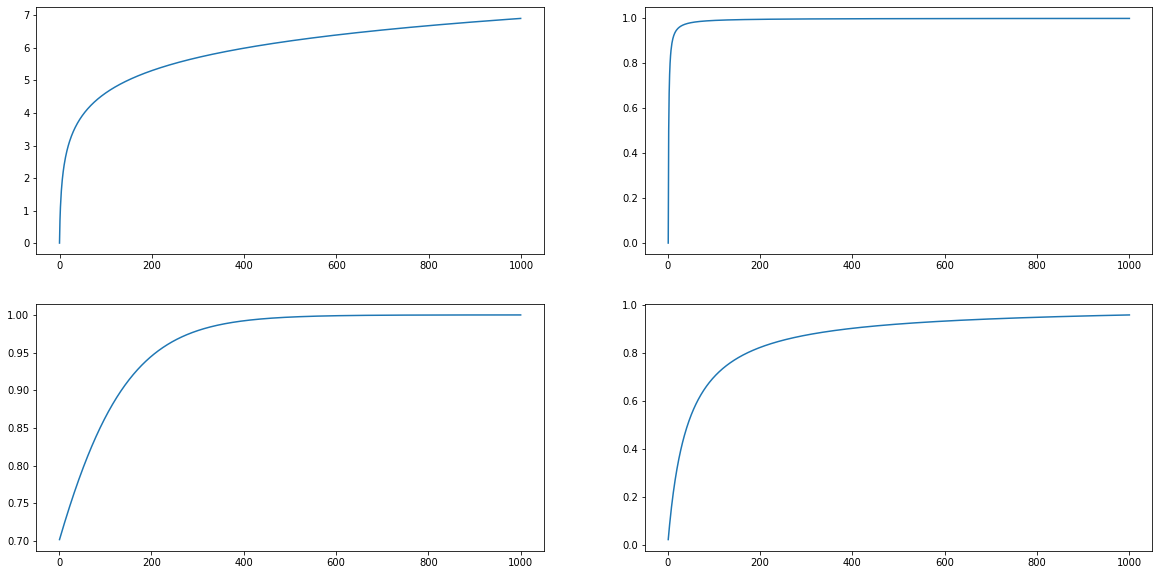

In [9]:
plt.figure(figsize = (20,10))

x = np.linspace(1, 1000, 1000, endpoint=True)
log_x = np.log(x)
plt.subplot(2,2,1)
plt.plot(log_x)

# y  = 1 - 1/np.exp(0.01*x)
y = 1 - 1/x
plt.subplot(2,2,2)
plt.plot(x, y)

# y  = 1 - 1/np.exp(0.001*log_x)
y = 0.7*np.exp(0.01*np.exp(log_x))/(1+0.7*(np.exp(0.01*np.exp(log_x))-1))
plt.subplot(2,2,3)
plt.plot(x, y)
# y  = 5 - 5/np.power(x,2)

# x = np.linspace(-50, 50, 100, endpoint=True)
# y = 1 / (1+1/np.exp(x))   # sigmoid

y = 0.7*0.01*np.exp(log_x)/(1+0.7*(0.01*np.exp(log_x)-1))
plt.subplot(2,2,4)
plt.plot(x, y)


plt.show()

C:\Users\S9041486\AppData\Local\Temp/ipykernel_10756/2115771710.py:73: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([l,l1,l2],labels=['lux','区间1','区间2'],loc='best')
C:\Users\S9041486\AppData\Local\Temp/ipykernel_10756/2115771710.py:88: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([l1,l,l2],labels=['区间1','luxlux','区间2'],loc='best')


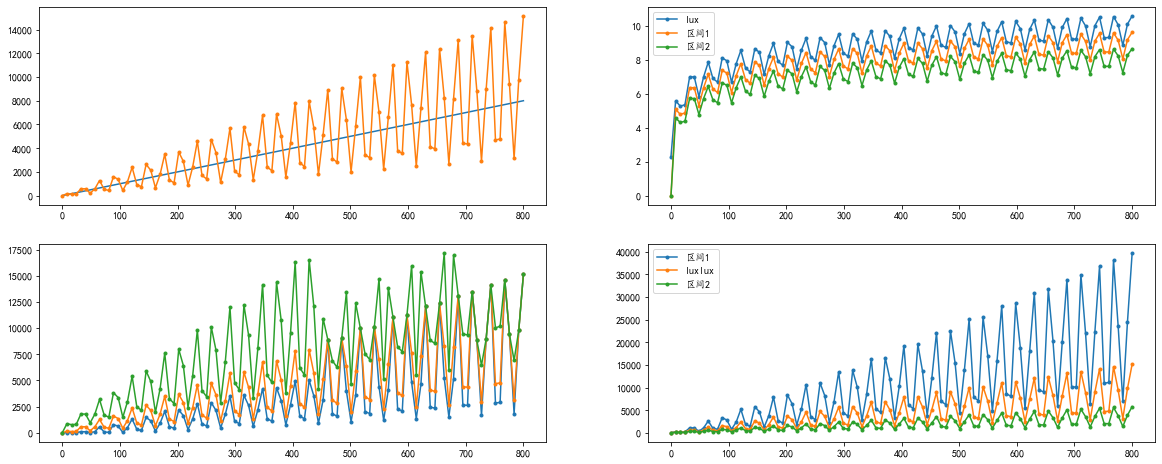

In [37]:
def stableBySection(lastStable):
    # left
    big_left = lastStable
    if lastStable < 30:
        big_left = lastStable / 4.0
    elif lastStable >= 30 and lastStable < 500:
        big_left = lastStable / 10.0 + 4.5
    elif lastStable >= 500 and lastStable < 8600:
        big_left = lastStable / 1.5 - 278.83
    
    # right
    big_right = lastStable
    if lastStable < 20:
        big_right = lastStable * 2.5
    elif lastStable >= 20 and lastStable < 35:
        big_right = lastStable * 36.0 - 670
    elif lastStable >= 35 and lastStable < 500:
        big_right = lastStable * 2.25 + 511.25
    elif lastStable >= 500 and lastStable < 8600:
        big_right = lastStable * 2.0 + 636.25
    big_right = max(5, big_right)

    # big_left = min(8600, big_left)
    # big_right = min(8600, big_right)
    return  big_left, big_right

plt.rcParams['font.sans-serif'] = ['KaiTi']

x = np.linspace(0, 800, 100, endpoint=True)
y  = 10*np.sin(x)
y = np.where(y<0, y*0.6, y)
y = x*y + 10*x + 1
z = 10*x + 1

# y = [1,2,3,8,16,36,60,100,260,540,1000,2250,4600,5900,8600]
# x = np.arange(0, len(y), 1)
log_y = np.log(y)
# log_y = np.log2(y)
add_y = np.add(np.multiply(y, 0.1), y)
sub_y = np.subtract(y, np.multiply(y, 0.1))

add_log_y = np.add(np.multiply(log_y, 0.1), log_y)
sub_log_y = np.subtract(log_y, np.multiply(log_y, 0.1))
add_log_y = np.where(add_log_y<math.log(10), math.log(10), add_log_y)
sub_log_y = np.where(add_log_y<0, 0, sub_log_y)
# add_log_y = np.multiply(log_y, 1.1)
# sub_log_y = np.multiply(log_y, 0.9)

e_add_log_y = np.exp(add_log_y)
e_sub_log_y = np.exp(sub_log_y)
e_log_y = np.exp(log_y)
# e_log_y = np.power(2, log_y)
# e_add_log_y = np.power(2, add_log_y)
# e_sub_log_y = np.power(2, sub_log_y)

big_left_list, big_right_list = [], []
for i in y:
    big_left, big_right = stableBySection(i) 
    big_left_list.append(big_left)
    big_right_list.append(big_right)

plt.figure(figsize = (20,8))

plt.subplot(2,2,1)
plt.plot(x, z)
plt.plot(x, y, marker='.')

plt.subplot(2,2,2)
l1=plt.plot(x, add_log_y, marker='.')
l=plt.plot(x, log_y, marker='.')
l2=plt.plot(x, sub_log_y, marker='.')
plt.legend([l,l1,l2],labels=['lux','区间1','区间2'],loc='best')

plt.subplot(2,2,3)
lim = 100
x = x[:lim]
# plt.plot(x, add_y, marker='.')
# plt.plot(x, sub_y, marker='.')
plt.plot(x, big_left_list[:lim], marker='.')
plt.plot(x, y[:lim], marker='.')
plt.plot(x, big_right_list[:lim], marker='.')

plt.subplot(2,2,4)
l1=plt.plot(x, e_add_log_y[:lim], marker='.')
l=plt.plot(x, e_log_y[:lim], marker='.')
l2=plt.plot(x, e_sub_log_y[:lim], marker='.')
plt.legend([l1,l,l2],labels=['区间1','luxlux','区间2'],loc='best')

plt.show()

4800.0


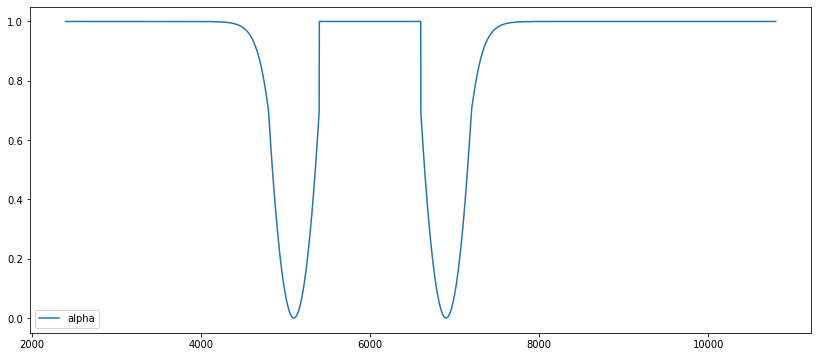

In [72]:
result = [6000]
a2 = 0.7
a1 = 0
factor = 0.1
factor2 = 0.2
last_min = max(0, result[-1] - result[-1]*factor)
last_max = max(5, result[-1] + result[-1]*factor)
last_min2 = max(0, result[-1] - result[-1]*factor2)
last_max2 = max(10, result[-1] + result[-1]*factor2)
linear = False

def calLogistic(deltaLux, a2):
    return a2*np.exp(0.01*deltaLux)/(1+a2*(np.exp(0.01*deltaLux)-1))

print(last_min2)
a_list = []
m = (a2-a1) / np.power((0.5*last_max - 0.5*last_max2), 2)
for cur_stable in range(int(last_min2*0.5), int(last_max2*1.5)):  # int(last_min2*0.8), int(last_max2*1.5)  0, 800
    if cur_stable <= last_max and cur_stable >= last_min:
        a = 1
    elif cur_stable > last_max2:
        a = calLogistic(cur_stable-last_max2, a2)
    elif cur_stable < last_min2:
        a = calLogistic(abs(last_min2-cur_stable), a2) 
    else:
        if linear:
            if cur_stable > last_max and cur_stable <= last_max2:
                a = (a1-a2)*(cur_stable-last_max2)/(last_max-last_max2) + a2
            elif cur_stable > last_min2 and cur_stable < last_min:
                a = (a1-a2)*(cur_stable-last_min2)/(last_min-last_min2) + a2
        else:
            if cur_stable > last_max and cur_stable <= last_max2:
                m = (a2-a1) / np.power((0.5*last_max - 0.5*last_max2), 2)
                a = m * np.power((cur_stable - 0.5*(last_max2+last_max)), 2) + a1
            elif cur_stable > last_min2 and cur_stable < last_min:
                m = (a2-a1) / np.power((0.5*last_min - 0.5*last_min2), 2)
                a = m * np.power((cur_stable - 0.5*(last_min2+last_min)), 2) + a1
    a_list.append(a)

plt.figure(figsize = (14,6))

x = np.linspace(int(last_min2*0.5), int(last_max2*1.5), len(a_list), endpoint=True)
plt.plot(x, a_list, label='alpha')  # , marker='.'
plt.legend(loc='best')

plt.show()